# Redes Neurais

## Preâmbulo

In [11]:
%matplotlib inline
import matplotlib.pyplot as plot
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

import time
import numpy as np
import numpy.random as nr
import pandas as pd
import tensorflow as tf

from keras.models import Sequential
from keras.layers.core import Dense, Flatten
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, TensorBoard
from keras.utils import np_utils

np.set_printoptions(precision=2, linewidth=100, suppress=True)

## Implementação matricial
- **Implementação com *bias* explícito.**

### Equações para regressão
Considerando uma amostra apenas (SGD).

#### Para a frente:

\begin{align*} 
\sigma(\mathbf{z}) & = \frac{1}{1+e^{-\mathbf{z}}} \\
\\
\mathbf{a}_{(i)} & = \begin{cases}
\mathbf{x}  & \text{ if } i = 0 \\
\\
\sigma(\mathbf{W}_{(i-1)} \cdot \mathbf{a}_{(i-1)} + \mathbf{b}_{(i-1)}) & \text{ if } 1 \leq i \leq L-1 \\
\\
\mathbf{W}_{(i-1)} \cdot \mathbf{a}_{(i-1)} + \mathbf{b}_{(i-1)} & \text{ if } i = L 
\end{cases}
\\
\\
J & = \frac{1}{2} (\mathbf{a}_{(L)} - \mathbf{y})^T \cdot (\mathbf{a}_{(L)} - \mathbf{y})
\end{align*}

#### Para trás:

\begin{align*} 
\boldsymbol{\delta}_{(i)} & = \begin{cases}
\mathbf{a}_{(i)} - \mathbf{y} & \text{ if } i = L \\
\\
\mathbf{W}_{(i)}^{T} \cdot \boldsymbol{\delta}_{(i+1)} \circ [ \mathbf{a}_{(i)} (1 - \mathbf{a}_{(i)}) ] & \text{ if } 1 \leq i \leq L-1 
\end{cases}
\\
\\
\boldsymbol{\nabla}_{\mathbf{W}}^{(i)} & = \boldsymbol{\delta}_{(i)} \cdot \mathbf{a}_{(i-1)}^{T}
\\
\\
\boldsymbol{\nabla}_{\mathbf{b}}^{(i)} & = \boldsymbol{\delta}_{(i)}
\\
\\
\mathbf{W}_{(i)} & = \mathbf{W}_{(i)} - \eta \boldsymbol{\nabla}_{\mathbf{W}}^{(i)}
\\
\\
\mathbf{b}_{(i)} & = \mathbf{b}_{(i)} - \eta \boldsymbol{\nabla}_{\mathbf{b}}^{(i)}
\end{align*}


### Equações para classificação
Considerando uma amostra apenas (SGD).

#### Para a frente:

\begin{align*} 
\sigma(\mathbf{z}) & = \frac{1}{1+e^{-\mathbf{z}}} \\
\\
\mathbf{a}_{(i)} & = \begin{cases}
\mathbf{x}  & \text{ if } i = 0 \\
\\
\sigma(\mathbf{W}_{(i-1)} \cdot \mathbf{a}_{(i-1)} + \mathbf{b}_{(i-1)}) & \text{ if } 1 \leq i \leq L \\
\end{cases}
\\
\\
J & = - \sum \left (\mathbf{y} \log{(\mathbf{a}_{(L)})} + (1 - \mathbf{y}) \log{(1 - \mathbf{a}_{(L)})} \right )
\end{align*}

#### Para trás:

\begin{align*} 
\boldsymbol{\delta}_{(i)} & = \begin{cases}
\mathbf{a}_{(i)} - \mathbf{y} & \text{ if } i = L \\
\\
\mathbf{W}_{(i)}^{T} \cdot \boldsymbol{\delta}_{(i+1)} \circ [ \mathbf{a}_{(i)} (1 - \mathbf{a}_{(i)}) ] & \text{ if } 1 \leq i \leq L-1 
\end{cases}
\\
\\
\boldsymbol{\nabla}_{\mathbf{W}}^{(i)} & = \boldsymbol{\delta}_{(i)} \cdot \mathbf{a}_{(i-1)}^{T}
\\
\\
\boldsymbol{\nabla}_{\mathbf{b}}^{(i)} & = \boldsymbol{\delta}_{(i)}
\\
\\
\mathbf{W}_{(i)} & = \mathbf{W}_{(i)} - \eta \boldsymbol{\nabla}_{\mathbf{W}}^{(i)}
\\
\\
\mathbf{b}_{(i)} & = \mathbf{b}_{(i)} - \eta \boldsymbol{\nabla}_{\mathbf{b}}^{(i)}
\end{align*}


### O código

In [12]:
class BackPropNeuralNetwork:
    
    def __init__(self, layer_sizes=[], is_classifier=True):
        self.L = len(layer_sizes)
        self.s = layer_sizes
        self.W = None
        self.b = None
        self.classifier = is_classifier
        self.costs = []

    def init_weights(self, epsilon=None):
        from numpy.random import rand
        self.W = []
        self.b = []
        for i in range(self.L-1):
            # Glorot Uniform
            eps = epsilon or np.sqrt(6.0 / (self.s[i] + self.s[i+1]))
            self.W.append(2*eps*rand(self.s[i+1], self.s[i]) - eps)
            self.b.append(np.zeros((self.s[i+1], 1), np.float))
            
    def predict(self, X):
        a = self.compute_activations(self.W, self.b, X)
        return a[-1]
    
    def evaluate(self, X, y):
        a = self.compute_activations(self.W, self.b, X)
        cost = self.compute_cost(a[-1], y)
        return cost
    
    def compute_cost_and_gradient(self, W, b, X, y):
        M, N  = X.shape
        Gw = [None for n in self.s[:-1]]
        Gb = [None for n in self.s[:-1]]
        # Forward propagation
        a = self.compute_activations(W, b, X)
        # Cost computation
        J = self.compute_cost(a[-1], y)
        # Back propagation
        d = self.compute_errors(W, a, y)
        # Gradients computation
        for j in range(self.L-1):
            Gw[j] = np.dot(d[j+1].T, a[j]) / M
            Gb[j] = np.dot(d[j+1].T, np.ones((M, 1))) / M
        # for txt, M in zip(['W', 'b', 'a', 'd', 'Gw', 'Gb'], [W, b, a, d, Gw, Gb]):
        #     print('{:3s}:'.format(txt), [m.shape for m in M if m is not None])  
        return J, Gw, Gb

    def compute_cost(self, y_pred, y_true):
        if self.classifier:
            # classifier: binary cross-entropy
            J = - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)).sum() / y_true.shape[0]
        else:
            # regressor: mean squared error
            J = 0.5 * np.square(y_true - y_pred).sum() / y_true.shape[0]
        return J
    
    def compute_activations(self, W, b, X):
        a = [None for n in self.s]
        a[0] = X
        for j in range(1, self.L):
            z = np.dot(a[j-1], W[j-1].T) + b[j-1].T
            if j == self.L-1 and not self.classifier:
                a[j] = z
            else:
                a[j] = self._logistic(z)
        return a            

    def compute_errors(self, W, a, y):
        d = [None for n in self.s]
        d[-1] = a[-1] - y
        for j in range(self.L-2, 0, -1):
            d[j] = np.dot(d[j+1], W[j]) * a[j] * (1 - a[j])
        return d

    def sgd(self, X, y, eta, batch, n_epochs, Xval=None, yval=None, verbose=0):
        m, n = X.shape
        n_batches = int(np.ceil(m / batch))
        
        for epoch in range(n_epochs):
            for ii in range(n_batches):
                kk = batch * ii
                X_batch, y_batch = X[kk:kk+batch], y[kk:kk+batch]
                
                cost, Gw, Gb = self.compute_cost_and_gradient(self.W, self.b, X, y)
                for i in range(len(self.W)):
                    self.W[i] -= eta * Gw[i]
                    self.b[i] -= eta * Gb[i]
                                
            if Xval is not None:
                cost_val = self.evaluate(Xval, yval)
                self.costs.append((epoch, cost, cost_val))
                if (verbose > 0) and (not epoch % verbose):
                    print(('{:4d} Training Cost: {:.5f}    Validation Cost: {:.5f}'.format(epoch, cost, cost_val)))
            else:
                self.costs.append((epoch, cost, 0))
                if (verbose > 0) and (not epoch % verbose):
                    print(('{:4d} Training Cost: {:.5f}'.format(epoch, cost)))

        return self.costs

    @staticmethod
    def _logistic(z):
        z = np.asarray(z)
        z = np.minimum(z,  15)
        z = np.maximum(z, -15)
        return np.ones(z.shape)/(1.0 + np.exp(-z))


# nnet = BackPropNeuralNetwork([10, 20, 5], is_classifier=False)
# nnet.init_weights();
# J, G, B = nnet.compute_cost_and_gradient(nnet.W, nnet.b, np.zeros((100, 10)), np.zeros((100, 5)))

### Verificando o cálculo do gradiente

Para fazer uma verificação numérica da correção de nossa implementação concatenamos cada matriz $W^{(L)}$ de forma a criar um vetor $\theta$ que contenha todos os pesos (e bias) de nossa rede neural.

Para calcular o gradiente, para cada elemento do vetor $\theta$ fazemos


$$
\theta^{(i+)} = \theta + \begin{bmatrix}
0 \\
0\\ 
\vdots \\ 
\epsilon \\ 
\vdots \\ 
0
\end{bmatrix} \; \; \; \; \; \; \text{ e }  \; \; \; \theta^{(i-)} = \theta - \begin{bmatrix}
0 \\
0\\ 
\vdots \\ 
\epsilon \\ 
\vdots \\ 
0
\end{bmatrix}
$$

Uma aproximação para o gradiente é dada por:

$$
\frac{\partial }{\partial \theta_i} J(\theta) \approx \frac{J(\theta^{(i+)}) - J(\theta^{(i-)})}{2 \epsilon}
$$

In [17]:
def compute_approx_gradient(nnet, W, b, X, y, eps=0.0001):
    def roll(q_flat, W=W):
        Q, m = [], 0
        for h, w in [t.shape for t in W]:
            Q.append(q_flat[m:m + h*w].reshape((h,w)))
            m += h*w
        return Q
    
    g_flat = np.concatenate([t.flat for t in W])
    ag_flat = np.zeros_like(g_flat)
    for i in range(g_flat.shape[0]):
        t_plus = g_flat.copy()
        t_plus[i] += eps            
        a_plus = nnet.compute_activations(roll(t_plus), b, X)
        J_plus = nnet.compute_cost(a_plus[-1], y)
        t_minus = g_flat.copy()
        t_minus[i] -= eps
        a_minus = nnet.compute_activations(roll(t_minus), b, X)
        J_minus = nnet.compute_cost(a_minus[-1], y)
        ag_flat[i] = (J_plus - J_minus) / (2*eps)

    b_flat = np.concatenate([t.flat for t in b])
    ab_flat = np.zeros_like(b_flat)
    for i in range(b_flat.shape[0]):
        b_plus = b_flat.copy()
        b_plus[i] += eps            
        a_plus = nnet.compute_activations(W, roll(b_plus, b), X)
        J_plus = nnet.compute_cost(a_plus[-1], y)
        b_minus = b_flat.copy()
        b_minus[i] -= eps
        a_minus = nnet.compute_activations(W, roll(b_minus, b), X)
        J_minus = nnet.compute_cost(a_minus[-1], y)
        ab_flat[i] = (J_plus - J_minus) / (2*eps)

    return ag_flat, ab_flat

def gradient_check(classif):
    nn = BackPropNeuralNetwork([4, 5, 3], is_classifier=classif)
    nn.init_weights()
    
    X = np.sin(np.arange(32)).reshape((8, 4)) / 10
    y = np.zeros((8, 3))
    for i, k in enumerate(np.mod(np.arange(8), 3)):
        y[i,k] = 1.0
    
    ag_flat, ab_flat = compute_approx_gradient(nn, nn.W, nn.b, X, y)
    J, G, B = nn.compute_cost_and_gradient(nn.W, nn.b, X, y)
    g_flat = np.concatenate([t.flat for t in G])
    b_flat = np.concatenate([t.flat for t in B])
    
    return np.allclose(ag_flat, g_flat) and np.allclose(ab_flat, b_flat)

print('Classificador:', ['Error', 'OK'][gradient_check(True)])
print('Regressor:    ', ['Error', 'OK'][gradient_check(True)])

Classificador: OK
Regressor:     OK


## Testes

### Dataset

In [4]:
# -----------------------------------------------------------------------------------------------------------
# Boston Housing Data Set
# -----------------------
# [https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names
#
# 1. Title: Boston Housing Data
# 
# 2. Sources:
#    (a) Origin:  This dataset was taken from the StatLib library which is
#                 maintained at Carnegie Mellon University.
#    (b) Creator:  Harrison, D. and Rubinfeld, D.L. 'Hedonic prices and the 
#                  demand for clean air', J. Environ. Economics & Management,
#                  vol.5, 81-102, 1978.
#    (c) Date: July 7, 1993
# 
# 3. Past Usage:
#    -   Used in Belsley, Kuh & Welsch, 'Regression diagnostics ...', Wiley, 
#        1980.   N.B. Various transformations are used in the table on
#        pages 244-261.
#     -  Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning.
#        In Proceedings on the Tenth International Conference of Machine 
#        Learning, 236-243, University of Massachusetts, Amherst. Morgan
#        Kaufmann.
# 
# 4. Relevant Information:
# 
#    Concerns housing values in suburbs of Boston.
# 
# 5. Number of Instances: 506
# 
# 6. Number of Attributes: 13 continuous attributes (including "class"
#                          attribute "MEDV"), 1 binary-valued attribute.
# 
# 7. Attribute Information:
# 
#     1. CRIM      per capita crime rate by town
#     2. ZN        proportion of residential land zoned for lots over 
#                  25,000 sq.ft.
#     3. INDUS     proportion of non-retail business acres per town
#     4. CHAS      Charles River dummy variable (= 1 if tract bounds 
#                  river; 0 otherwise)
#     5. NOX       nitric oxides concentration (parts per 10 million)
#     6. RM        average number of rooms per dwelling
#     7. AGE       proportion of owner-occupied units built prior to 1940
#     8. DIS       weighted distances to five Boston employment centres
#     9. RAD       index of accessibility to radial highways
#     10. TAX      full-value property-tax rate per $10,000
#     11. PTRATIO  pupil-teacher ratio by town
#     12. B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
#     13. LSTAT    % lower status of the population
#
#     14. MEDV     Median value of owner-occupied homes in $1000's
# 
# 8. Missing Attribute Values:  None.
# -----------------------------------------------------------------------------------------------------------
from keras.datasets import boston_housing
(Xtra, ytra), (Xval, yval) = boston_housing.load_data()

mean = Xtra.mean(0)
Xtra -= mean
std = Xtra.std(0)
Xtra /= std

Xval -= mean
Xval /= std

ytra = ytra.reshape(-1, 1)
yval = yval.reshape(-1, 1)

m, n = Xtra.shape
print('Shapes:', Xtra.shape, Xval.shape, ytra.shape, yval.shape)
print('Target: min={:.3f}, mean={:.3f}, max={:.3f}'.format(ytra.min(), ytra.mean(), ytra.max()))

Shapes: (404, 13) (102, 13) (404, 1) (102, 1)
Target: min=1.730, mean=12.741, max=37.970


\begin{align*} 
\mathbf{X}_{train} & = \begin{bmatrix}
\longleftarrow & (\mathbf{x}^{(0)})^T & \longrightarrow \\ 
\longleftarrow & (\mathbf{x}^{(1)})^T & \longrightarrow \\ 
  & \vdots  & \\ 
\longleftarrow & (\mathbf{x}^{(m-1)})^T & \longrightarrow 
\end{bmatrix} = \begin{bmatrix}
x_0^{(0)} & x_1^{(0)} & x_2^{(0)} & \ldots & x_{12}^{(0)} \\
x_0^{(1)} & x_1^{(1)} & x_2^{(1)} & \ldots & x_{12}^{(1)} \\
 &  & \vdots  & \\ 
x_0^{(403)} & x_1^{(403)} & x_2^{(403)} & \ldots & x_{12}^{(403)}
\end{bmatrix} \\
\\
\mathbf{y}_{train} & = \begin{bmatrix}
y^{(0)} \\
y^{(1)} \\
\vdots  \\ 
y^{(403)} \\
\end{bmatrix}
\end{align*}


### Testando nossa implementação

In [5]:
layer_sizes = [n, 40, 20, 1]
n_epochs = 10000

nnet = BackPropNeuralNetwork(layer_sizes, is_classifier=False)
nnet.init_weights();

try:
    t1 = t0 = time.time()
    costs = nnet.sgd(Xtra, ytra, 0.1, 101, n_epochs, Xval=Xval, yval=yval, verbose=n_epochs/10)
    t1 = time.time()
except KeyboardInterrupt:
    pass

print('\nTrained in {:2f}s'.format(t1-t0))
yhat = nnet.predict(Xval)
mse = np.square(yhat - yval).mean()
print('\nMSE:', mse)
print()
print('y_hat', yhat[:10,0])
print('y_val', yval[:10,0])


   0 Training Cost: 22.58283    Validation Cost: 17.43773
1000 Training Cost: 0.00785    Validation Cost: 0.01253
2000 Training Cost: 0.00356    Validation Cost: 0.00675
3000 Training Cost: 0.00214    Validation Cost: 0.00481
4000 Training Cost: 0.00145    Validation Cost: 0.00384
5000 Training Cost: 0.00108    Validation Cost: 0.00329
6000 Training Cost: 0.00085    Validation Cost: 0.00296
7000 Training Cost: 0.00070    Validation Cost: 0.00275
8000 Training Cost: 0.00059    Validation Cost: 0.00261
9000 Training Cost: 0.00051    Validation Cost: 0.00250

Trained in 65.684177s

MSE: 0.00482227078726

y_hat [ 29.2   16.24   9.76   5.58   8.46  13.61   4.53   7.51  17.92  14.38]
y_val [ 29.05  16.21   9.74   5.5    8.44  13.59   4.61   7.51  17.93  14.36]


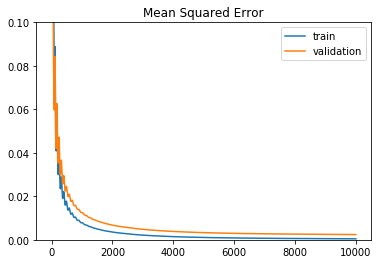

In [6]:
plot.plot([c1 for i, c1, c2 in costs], label='train')
plot.plot([c2 for i, c1, c2 in costs], label='validation')
plot.ylim(0, 0.1)
plot.legend()
plot.title('Mean Squared Error');


### TensorFlow

### Keras

In [7]:
estop = EarlyStopping(patience=500, verbose=1)

def build():
    model = Sequential()
    model.add(Dense(layer_sizes[1], activation='sigmoid', input_shape=(layer_sizes[0],)))
    model.add(Dense(layer_sizes[2], activation='sigmoid'))
    model.add(Dense(layer_sizes[3], activation=None))
    return model

nnet = build()
nnet.summary()

opt = SGD(lr=0.01)
nnet.compile(loss="mse", optimizer=opt, metrics=["mae"])    

try:
    t0 = time.time()
    histo2 = nnet.fit(Xtra, ytra, batch_size=101, epochs=n_epochs, verbose=0, 
                      validation_data=(Xval, yval), callbacks=[estop])
    t1 = time.time()
except KeyboardInterrupt:
    pass

print('\nTrained in {:2f}s'.format(t1-t0))
print()
yhat = nnet.predict(Xval, verbose=0)
mse = np.square(yhat - yval).mean()
print('MSE:', mse)
print()
print('y_hat', yhat[:10,0])
print('y_val', yval[:10,0])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 40)                560       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 1,401
Trainable params: 1,401
Non-trainable params: 0
_________________________________________________________________

Trained in 42.209722s

MSE: 0.00807557228087

y_hat [ 29.29  16.22   9.78   5.48   8.49  13.59   4.42   7.5   17.91  14.36]
y_val [ 29.05  16.21   9.74   5.5    8.44  13.59   4.61   7.51  17.93  14.36]


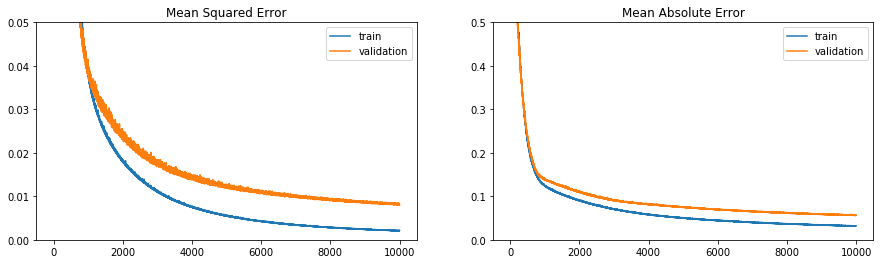

In [8]:
fig = plot.figure(figsize=(15,4))

fig.add_subplot(121)
plot.plot(histo2.history['loss'], label='train')
plot.plot(histo2.history['val_loss'], label='validation')
plot.ylim(0, 0.05)
plot.legend()
plot.title('Mean Squared Error');

fig.add_subplot(122)
plot.plot(histo2.history['mean_absolute_error'], label='train')
plot.plot(histo2.history['val_mean_absolute_error'], label='validation')
plot.ylim(0, 0.5)
plot.legend()
plot.title('Mean Absolute Error');


In [9]:
print(histo2.history['val_loss'][-5:])
print([c2 for i, c1, c2 in costs][-5:])

[0.0082572766570556989, 0.0081577501396703361, 0.0082389489478230764, 0.0081831532811252952, 0.0080755676825384742]
[0.0024114498035337746, 0.0024113711759739974, 0.0024112925651587412, 0.0024112139710548738, 0.0024111353936287117]
